In [1]:
from IPython import get_ipython
import os 
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

# check if we use colab or local machine
if 'google.colab' in str(get_ipython()):
    IS_COLAB = True
    print('Running on colab')
else:
    IS_COLAB = False
    print('Running on local machine')

if IS_COLAB:
    git_root = !git rev-parse --show-toplevel
    already_in_repo = os.path.exists(git_root[0])

    if not already_in_repo:
        !git clone https://github.com/Albly/Sparce_image_reconstruction $repo_dir

    sys.path.append('Sparce_image_reconstruction')

else:
    os.chdir(Path().absolute().parent)

Running on local machine


# Load a random image

Batch of images has shape:  torch.Size([1, 512, 512])
Batch of labels:  tensor([6])
Dataset length = 83


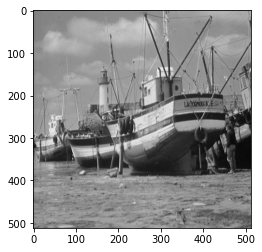

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from dataloader import CustomDataset

# path to dataset images
path = 'datasets/USC_SIPI/'
# create dataset
usc_sipi_set = CustomDataset(path)
# create dataloader
usc_sipi_loader = DataLoader(usc_sipi_set, batch_size=1, shuffle=True)
# test dataloader
for imgs, labels in usc_sipi_loader:
    print("Batch of images has shape: ",imgs.shape)
    print("Batch of labels: ", labels)
    plt.imshow(imgs[0,:,:],cmap='gray')
    break
print('Dataset length =',len(usc_sipi_set))

# Study metrics

$\mathbf{RMSE} = \frac{1}{MN} \sum_{i=0}^{M} \sum_{j=0}^{N} \big| \mathbf{I}(i,j) - \hat{\mathbf{I}}(i,j)\big|^2$, where

$\mathbf{I}$ - original image;

$\hat{\mathbf{I}}$ - distorted image;

$M$ - image height;

$N$ - image width.

$\mathbf{PSNR} = 10 \log_{10}{ \big( \frac{\mathbf{MAX_I}}{\mathbf{RMSE}}\big)^2}$, where

$\mathbf{MAX_I}$ - maximal possible intensity in the image;

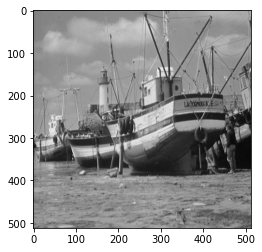

In [43]:
img_original = imgs[0]
plt.imshow(img_original,cmap='gray')

# Try low-rank approximation to destroy the image

$\mathbf{I} = \mathbf{U S V}^T, \mathbf{U} \in \mathbb{R}^{m \times k},\mathbf{S} \in \mathbb{R}^{k \times k},\mathbf{V} \in \mathbb{R}^{n \times k}$

For low-rank approximation: $r < k$.

$\hat{\mathbf{I}} = \mathbf{U}_r \mathbf{S}_r \mathbf{V}_r, \mathbf{U}_r \in \mathbb{R}^{m \times r},\mathbf{S}_r \in \mathbb{R}^{r \times r},\mathbf{V}_r \in \mathbb{R}^{n \times r}$

In [50]:
# SVD
U,S,V = torch.linalg.svd(img_original)

# approximation
r = 100
img_rec = U[:,:r] @ torch.diag(S[:r]) @ V[:r,:]

# consider value constraints
img_rec[img_rec > 255] = 255
img_rec[img_rec < 0] = 0

# change data type
img_rec = img_rec.to(torch.uint8)

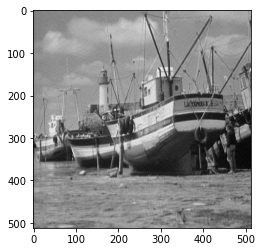

In [51]:
plt.imshow(img_rec,cmap='gray')

In [52]:
from metrics import PSNR,MSE,NMSE

print(PSNR(img_original,img_rec))
print(MSE(img_original,img_rec))
print(NMSE(img_original,img_rec))

tensor(33.1191)
tensor(31.7085)
tensor(0.0017)
